In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [3]:
df = pd.read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")
cat_cols = {
    "Job": [0, 1, 2, 3],
    "Saving accounts": ['little', 'quite rich', 'rich'], 
    "Risk": ["good", "bad"]
}

for col, categories in cat_cols.items():
    df[col] = pd.Categorical(df[col], categories=categories, ordered=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Duration         939 non-null    Int64   
 1   Credit amount    928 non-null    Int64   
 2   Purpose          934 non-null    category
 3   Job              947 non-null    category
 4   Sex              937 non-null    category
 5   Saving accounts  667 non-null    category
 6   Housing          943 non-null    category
 7   Risk             936 non-null    category
 8   Age              958 non-null    Int64   
dtypes: Int64(3), category(6)
memory usage: 32.4 KB


Let's get missing values per column

In [7]:
df.isnull().sum()

Duration            27
Credit amount       38
Purpose             32
Job                 19
Sex                 29
Saving accounts    299
Housing             23
Risk                30
Age                  8
dtype: int64

# Univariate analysis 

## Numerical columns

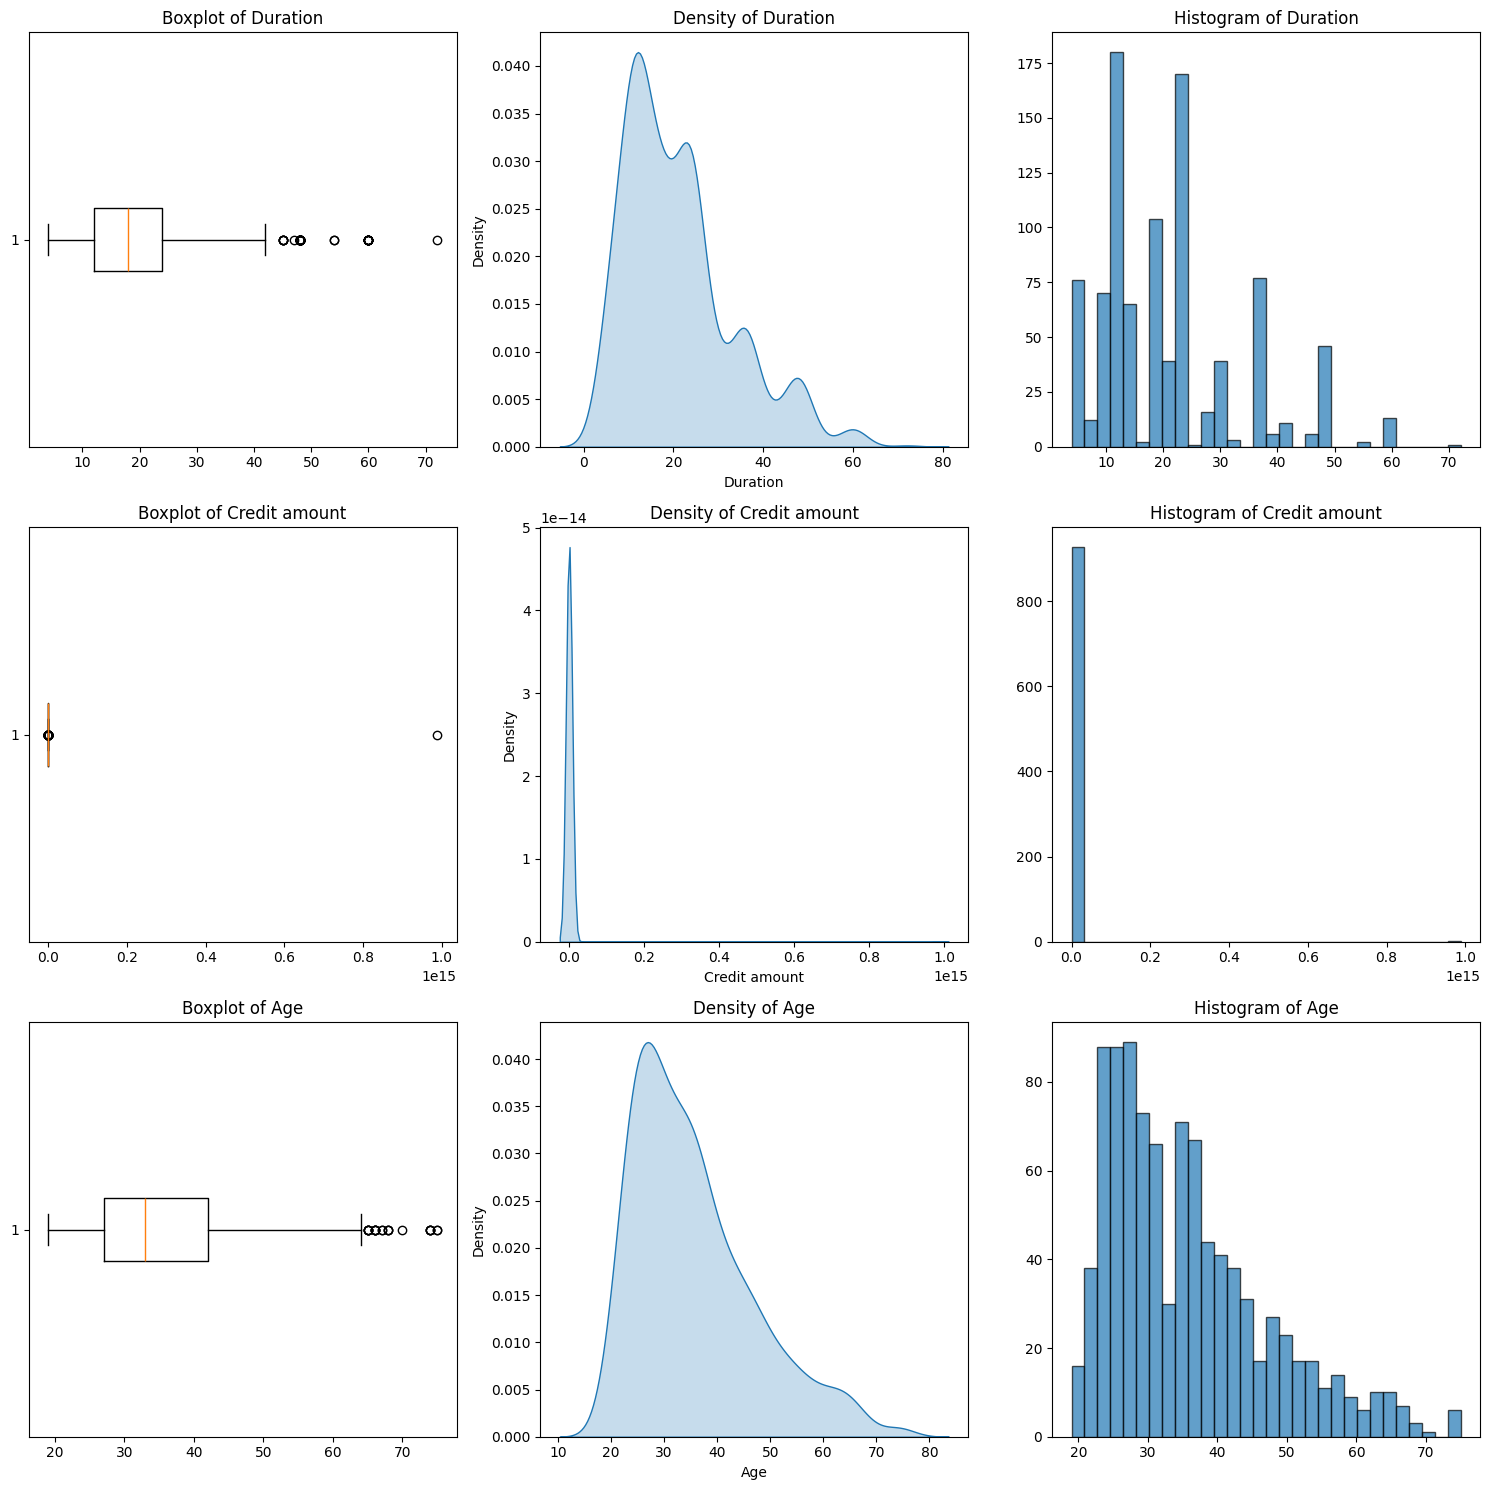

In [22]:
num_cols = list(df.select_dtypes(include=["number"]).columns)

fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    axes[i, 0].boxplot(df[col].dropna(), vert=False)
    axes[i, 0].set_title(f"Boxplot of {col}")

    # Density plot (approximation using histogram)
    sns.kdeplot(df[col], fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Density of {col}")

    # Histogram
    axes[i, 2].hist(df[col].dropna(), bins=30, edgecolor="black", alpha=0.7)
    axes[i, 2].set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

Credit amount has clearly got an outlier.

## Categorical variables

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Duration         939 non-null    Int64   
 1   Credit amount    928 non-null    Int64   
 2   Purpose          934 non-null    category
 3   Job              947 non-null    category
 4   Sex              937 non-null    category
 5   Saving accounts  667 non-null    category
 6   Housing          943 non-null    category
 7   Risk             936 non-null    category
 8   Age              958 non-null    Int64   
dtypes: Int64(3), category(6)
memory usage: 32.4 KB


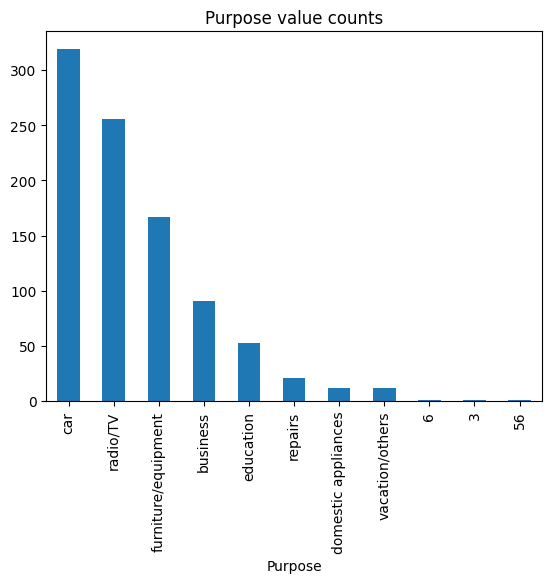

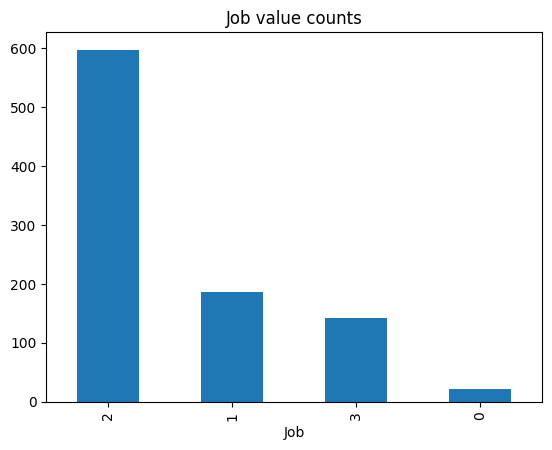

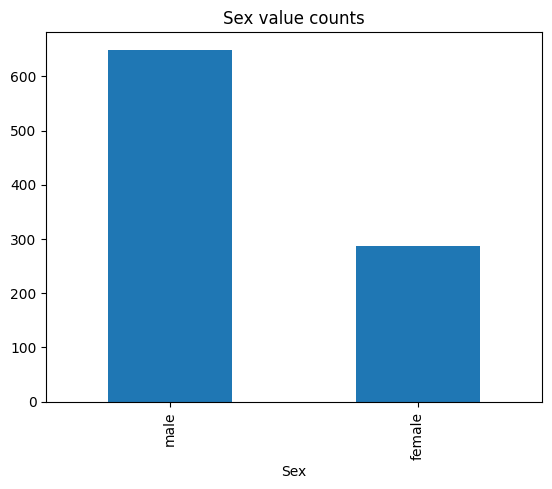

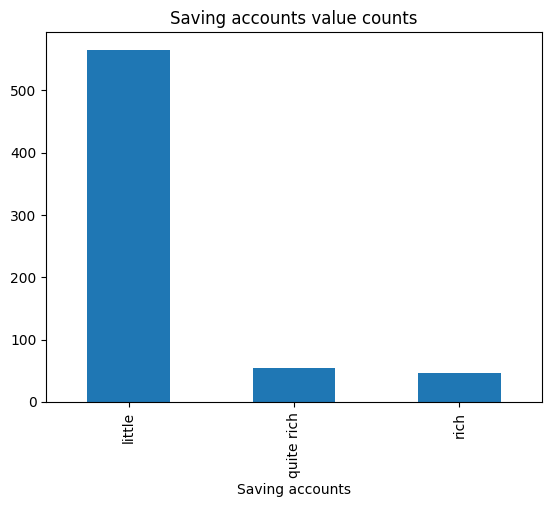

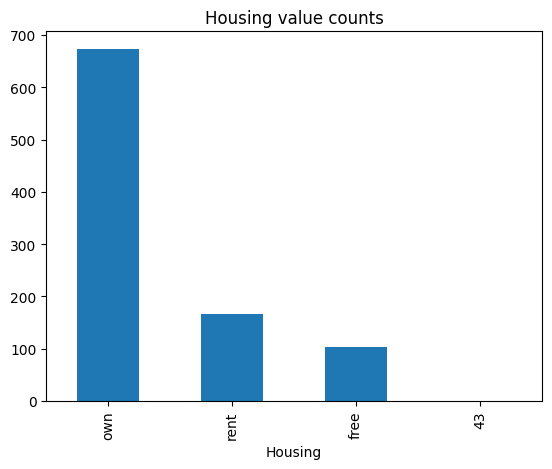

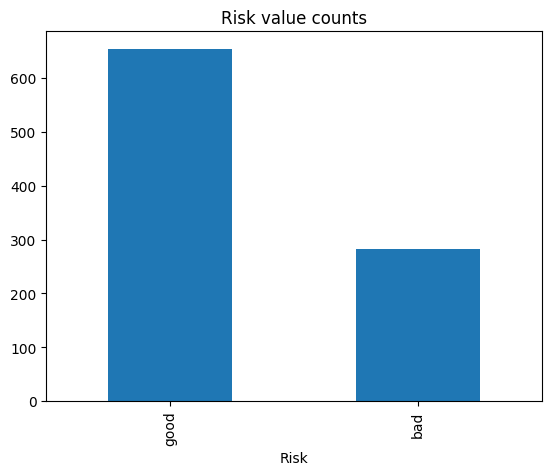

In [32]:
cat_cols = list(df.select_dtypes(include=["category"]).columns)

for col in cat_cols:
    df[col].value_counts().plot(
        kind="bar", title = f"{col} value counts"
    )
    plt.show()

# Bivariate analysis

## Target vs numerical vars

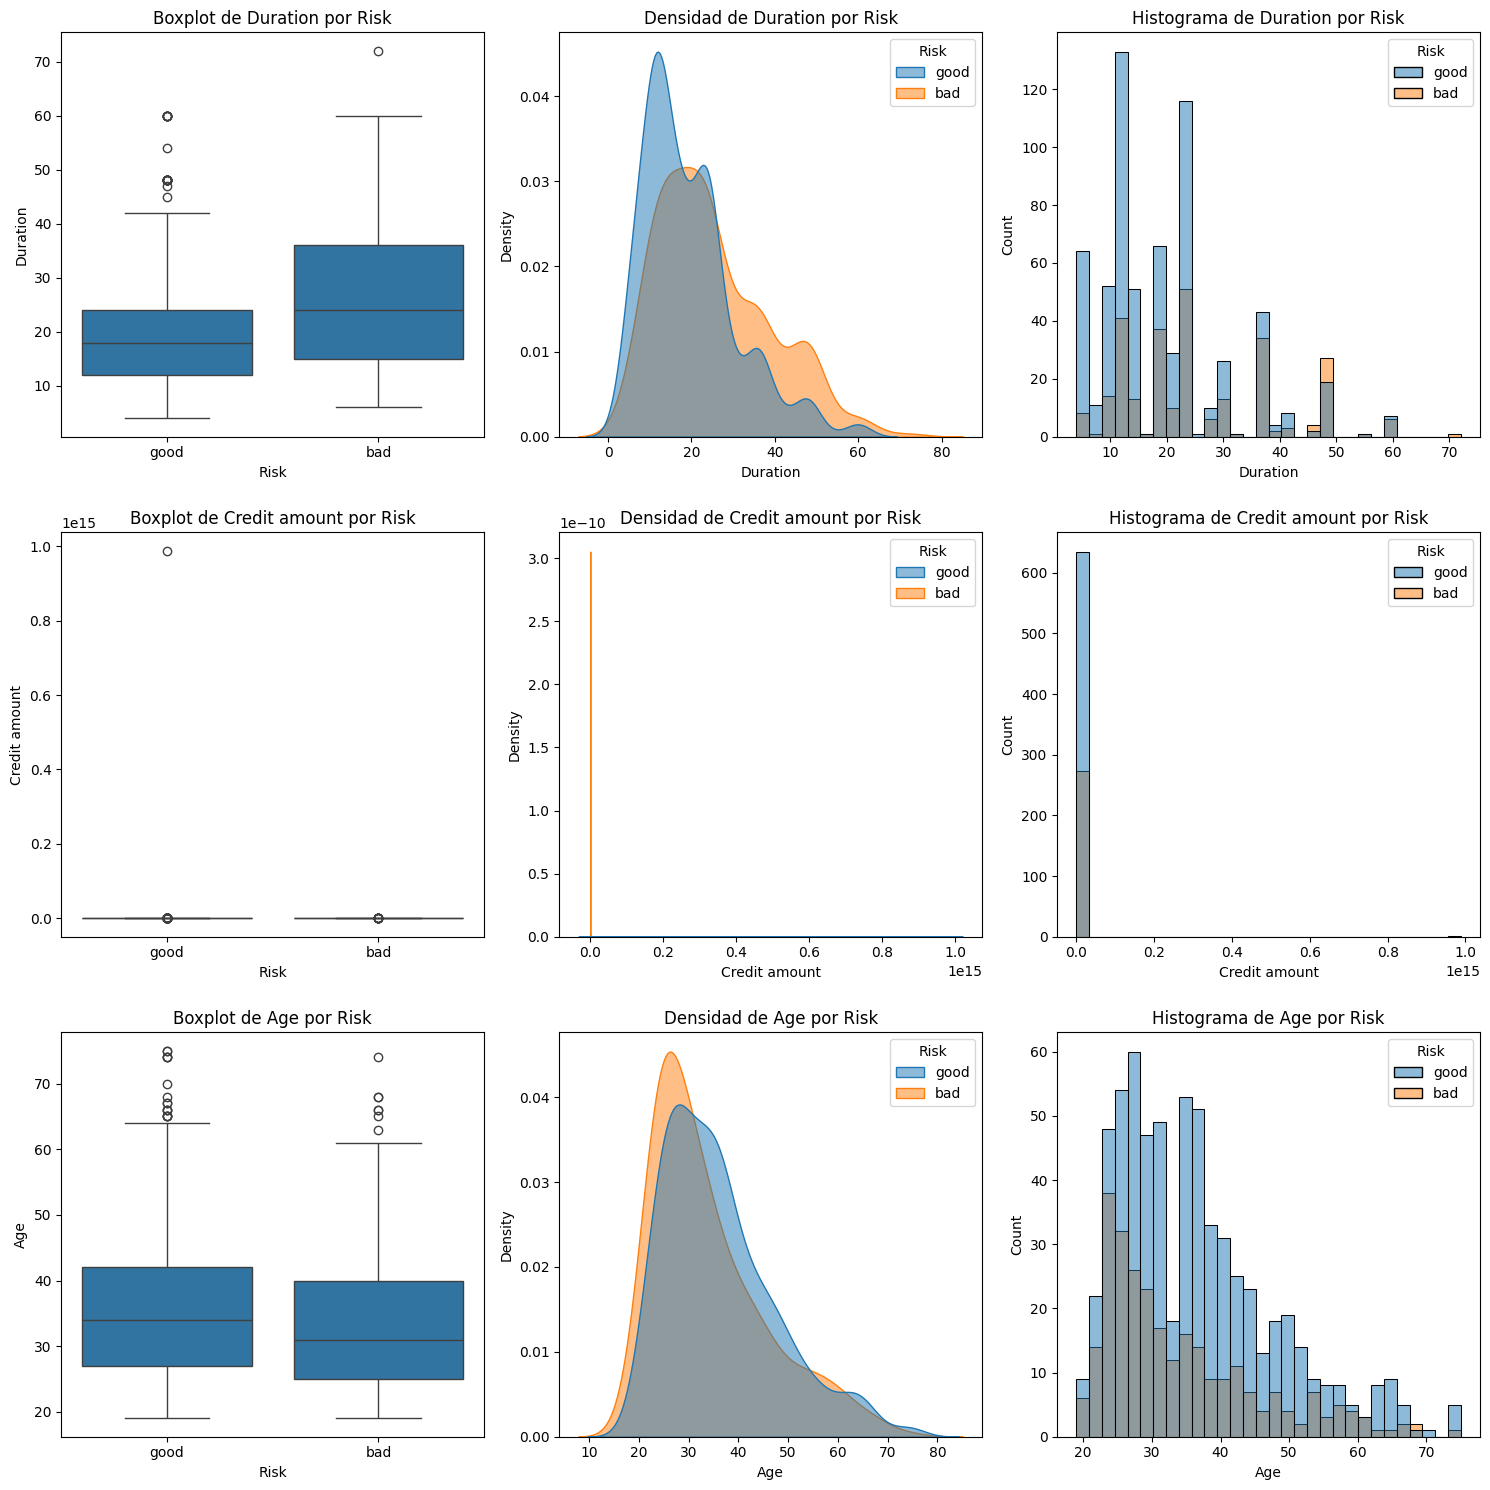

In [36]:
fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.boxplot(x="Risk", y=col, data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {col} por Risk")
    
    sns.kdeplot(data=df, x=col, hue="Risk", fill=True, common_norm=False, alpha=0.5, ax=axes[i, 1])
    axes[i, 1].set_title(f"Densidad de {col} por Risk")
    
    sns.histplot(data=df, x=col, hue="Risk", bins=30, kde=False, alpha=0.5, ax=axes[i, 2])
    axes[i, 2].set_title(f"Histograma de {col} por Risk")

plt.tight_layout()
plt.show()

## Target vs categorical vars

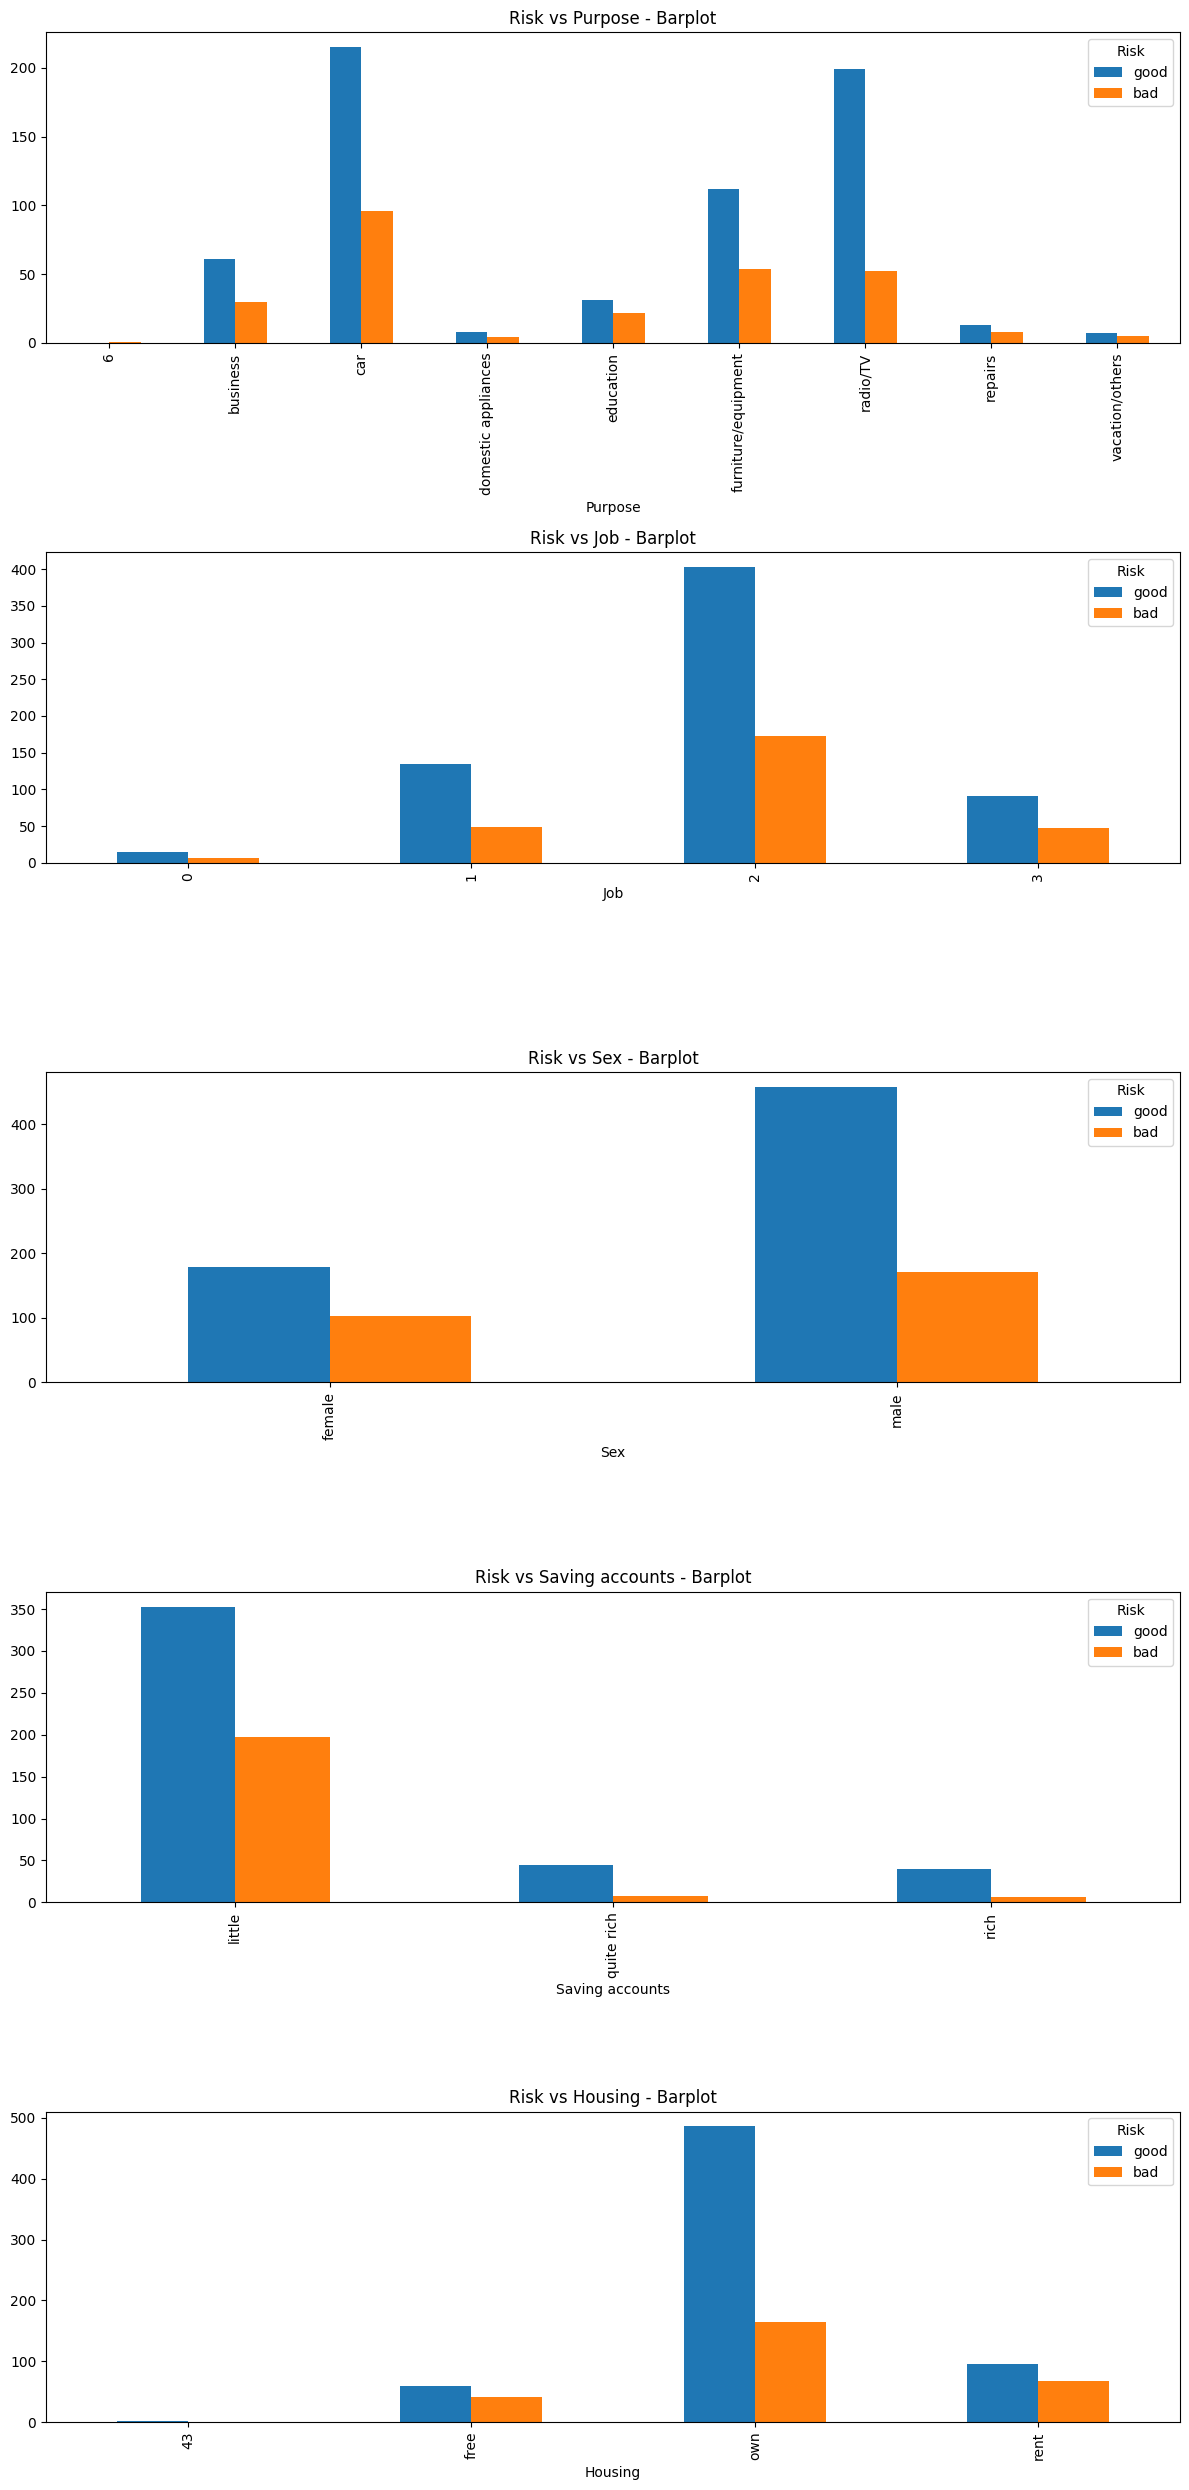

In [37]:
cat_cols = [col for col in cat_cols if col != "Risk"]

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 5 * max(len(cat_cols), 1)))

for i, col in enumerate(cat_cols):
    pd.crosstab(df[col], df["Risk"]).plot(
        kind="bar",
        ax=axes[i],
        title=f"Risk vs {col} - Barplot"
    )
plt.tight_layout()
plt.show()

## Numerical vs numerical

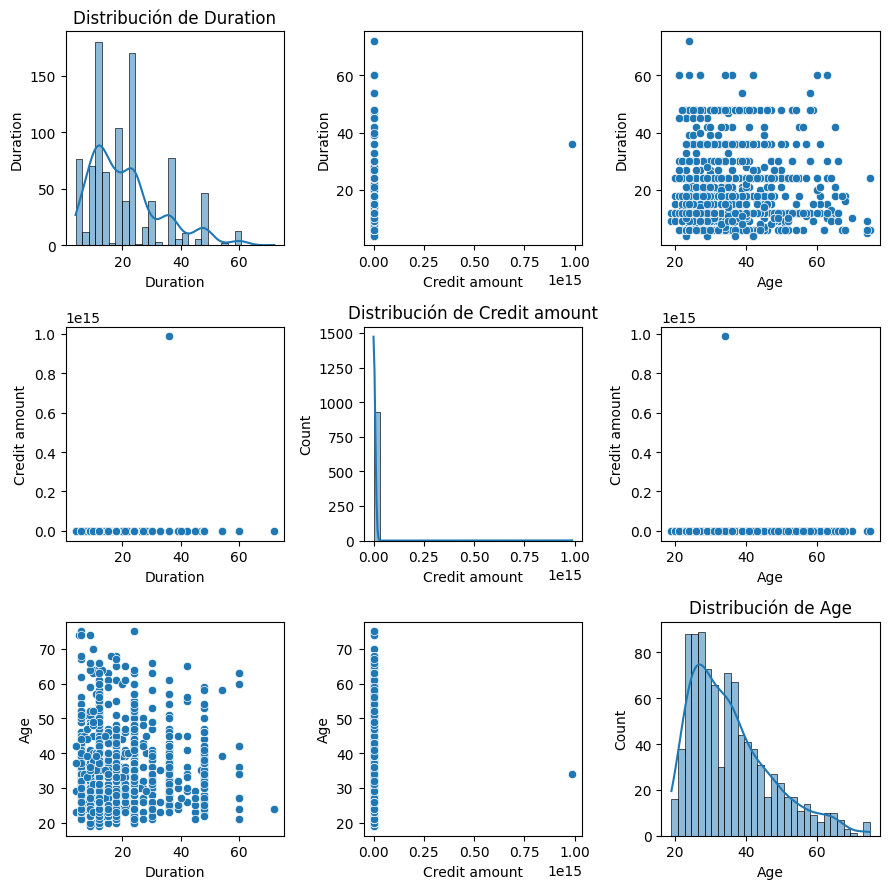

In [ ]:
num_vars = len(num_cols)
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(3 * num_vars, 3 * num_vars))

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        ax = axes[i, j]
        if i == j:
            sns.histplot(df[col1], bins=30, kde=True, ax=ax)
            ax.set_title(f"Distribución de {col1}")
        else:
            sns.scatterplot(x=df[col2], y=df[col1], ax=ax)
        
        if j == 0:
            ax.set_ylabel(col1)
        if i == num_vars - 1:
            ax.set_xlabel(col2)
plt.tight_layout()
plt.show()

## Categorical vs categorical

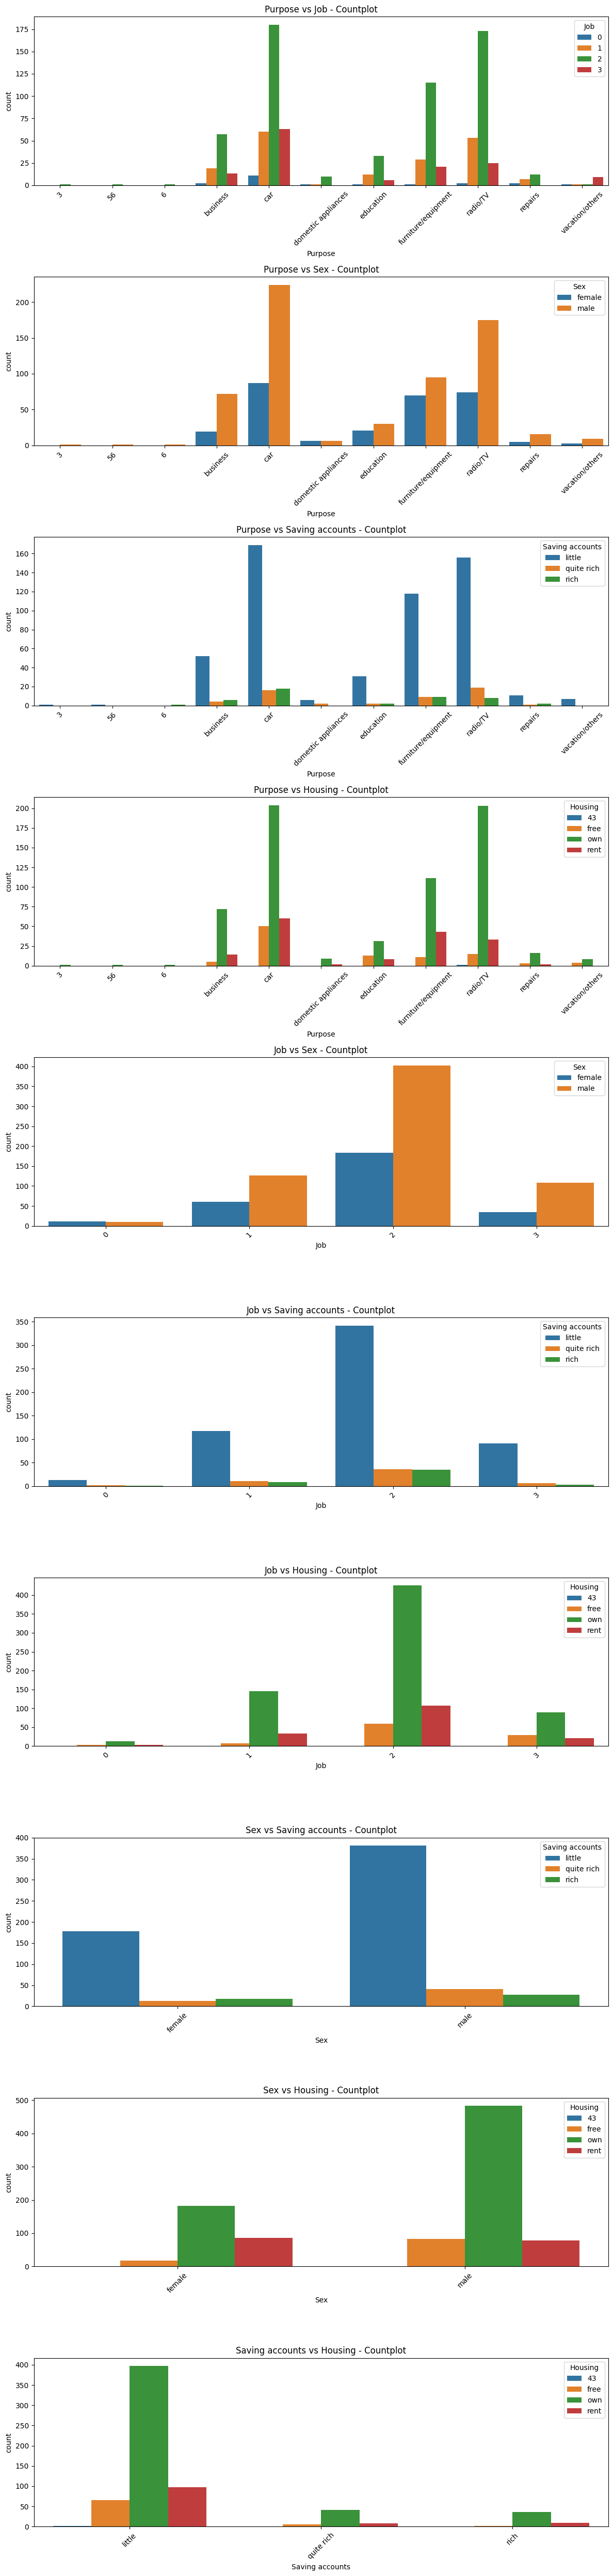

In [ ]:
cat_combinations = list(combinations(cat_cols, 2))
num_plots = len(cat_combinations)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, 5 * max(num_plots, 1)))

for i, (col1, col2) in enumerate(cat_combinations):
    sns.countplot(data=df, x=col1, hue=col2, ax=axes[i])
    axes[i].set_title(f"{col1} vs {col2} - Countplot")
    axes[i].tick_params(axis='x', rotation=45) 
plt.tight_layout()
plt.show()

## Categorical vs numerical

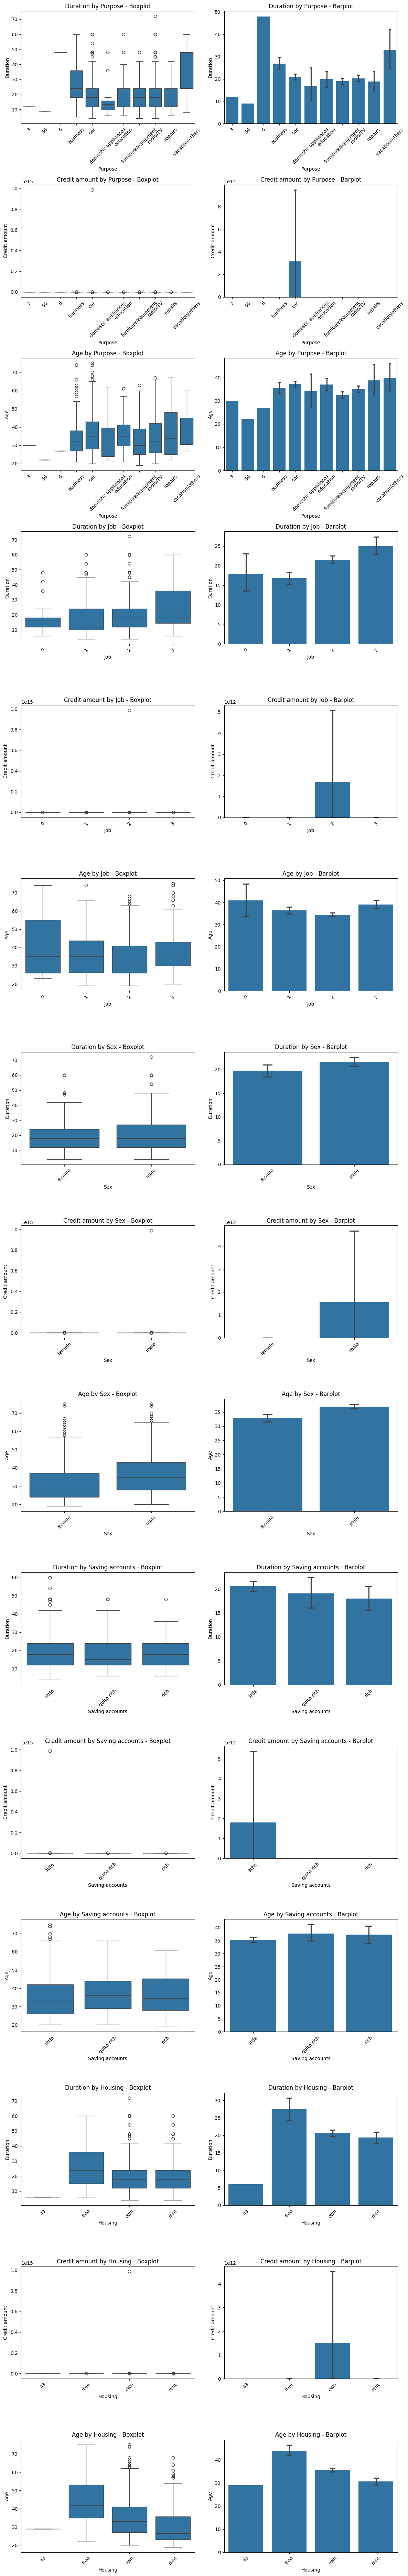

In [42]:
combinations = [(cat, num) for cat in cat_cols for num in num_cols]
num_plots = len(combinations)

fig, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(12, 5 * num_plots))

for i, (cat, num) in enumerate(combinations):
    sns.boxplot(data=df, x=cat, y=num, ax=axes[i][0])
    axes[i][0].set_title(f"{num} by {cat} - Boxplot")
    axes[i][0].tick_params(axis='x', rotation=45)
    
    sns.barplot(data=df, x=cat, y=num, errorbar="ci", capsize=0.1, ax=axes[i][1])
    axes[i][1].set_title(f"{num} by {cat} - Barplot")
    axes[i][1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Multivariate analysis

## Numerical vs all numerical

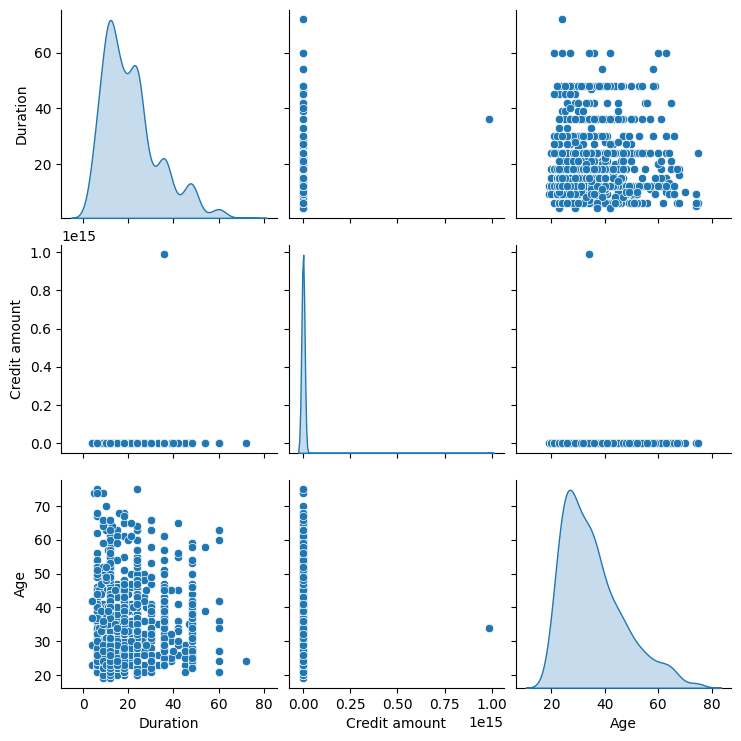

In [48]:
sns.pairplot(df[num_cols], diag_kind="kde")

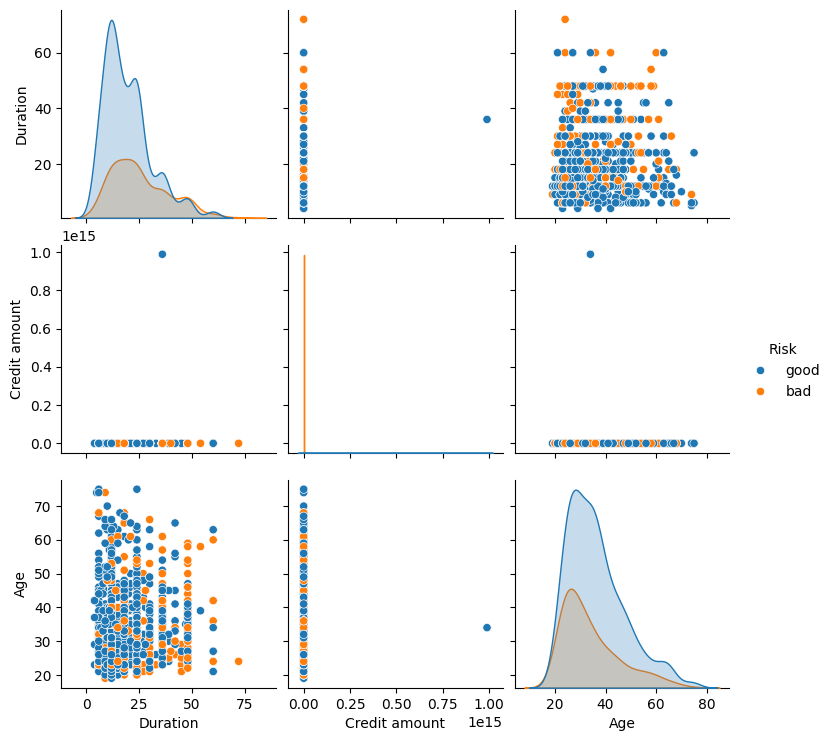

In [49]:
risk = df[[*num_cols, "Risk"]]
sns.pairplot(risk, hue="Risk", diag_kind="kde")